# Variables to update

In [33]:
# Specify the base directory
base_dir = "/Users/gabefoley/Dropbox/PhD/Projects/Phylo_Island/2020/20200309_RBD/20200331_RBD_Notebook"
os.chdir(base_dir)

# Specify the A region file
# filename = 'All_A_Regions_and_Expanded'
# filename = 'A_region_test'
# filename = 'All_A_Regions_w_Leidreiter_A_regions_multiples_tagged_and_Expanded'
filename = 'output'

tag_dict = {"NC_017807.1": "type_2B", "NZ_LLWJ01000072.1": "various", "NZ_CP014947.1": "type_2B", "NZ_AMBZ01000025.1": "type_1", "NZ_CP029064.1": "type_3", "NZ_LLWJ01000072.1_information_Pseudomonas_sp._region_A1_expanded_1246161_1249020_forward": "type_2B", "NZ_LLWJ01000072.1_information_Pseudomonas_sp._region_A2_expanded_1249050_1253874_forward": "type_2B", "NZ_LLWJ01000072.1_information_Pseudomonas_sp._region_TcdA1_expanded_1227724_1236094_forward": "type_3"}

# Specify the outgroup
# outgroup = 'NZ_AMBZ01000025.1_info_Paenibacillus_alvei_TcdA1_expanded_position_1274632_1281550_backward'
outgroup = 'NZ_AMBZ01000025.1_information_Paenibacillus_alvei_region_TcdA1_expanded_1274632_1281550_backward'

# Specify the profile name and load the profile_dict
profile_name = 'leidreiter_profiles'

# Define the colours to use for each type - list of colours are here - http://etetoolkit.org/docs/latest/reference/reference_treeview.html
colour_dict = {'type_1' :'dodgerblue', 'type_2B': 'gold', 'type_2A':'green', 'type_3' :'purple', 'various' : 'red', 'unknown' : 'black'}

# Code to visualise phylogenetic tree

In [40]:
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node, SeqMotifFace, NodeStyle, faces, ImgFace, CircleFace, AttrFace
from IPython.display import display

def get_domains(domains):
    
    pos_dict = {'RBD_A' : 0, 'RBD_C' : 1, 'RBD_B' : 2, 'NMD' : 3, 'RBD_D' : 4, 'TcB_BD_seed' : 5}

    
    domain_list = [
        # seq.start, seq.end, shape, width, height, fgcolor, bgcolor
        [10,  70, "[]", None, 20, "black", "rgradient:lightgreen", "arial|3|black|RBD_A"],
        [80, 140, "[]", None, 20, "black", "rgradient:blue", "arial|3|black|RBD_C"],
        [150, 210, "[]", None, 20, "black", "rgradient:orange", "arial|3|black|RBD_B"],
        [220, 280, "[]", None, 20, "black", "rgradient:purple", "arial|3|black|NMD"],
        [290, 350, "[]", None, 20, "black", "rgradient:gray", "arial|3|black|RBD_D"],
        [360, 430, "[]", None, 20, "black", "rgradient:darkgreen", "arial|3|black|TCB_BD"]]
    
    
    for k,v in pos_dict.items():
        if k not in domains:
            domain_list[v][6] = 'white'
            domain_list[v][7] = "arial|3|black|"
            
    return domain_list


def get_example_tree(tree, attribute_dict, tag_dict, colour_dict, region_dict):
            
            colour = None

            # Label all internal nodes
            edge = 0
            for node in tree.traverse():
                if not node.is_leaf():
                    node.name = "N%d" % edge
                    edge += 1

            # Get the colours for each extant genome
            for node in tree.iter_descendants("postorder"):
                if node.is_leaf():
                    long_name = node.name.split("_joined")[0]
                    short_name = node.name.split("_information")[0]
                    if long_name in tag_dict:
                        colour = colour_dict[tag_dict[long_name]]
                    elif short_name in tag_dict:
                        colour = colour_dict[tag_dict[short_name]]
                    else:
                        colour = 'black'
                    spaced_name = " ".join(node.name.split("_")[3:5])

                    nameFace = TextFace("  " + spaced_name, fsize=15, fgcolor='black')
                    
                    box_domains = get_domains([x for x in region_dict[node.name].keys()])
                    
                    seqFace = SeqMotifFace(seq=None, motifs=box_domains, gap_format="line")
                    node.add_face(seqFace, 0, "aligned")

                    node.add_face(nameFace, column=0)

                else:
                    colour = 'black'
                    
                if colour == None:
                    colour = 'black'

                nstyle = NodeStyle()
                nstyle["fgcolor"] = colour
                nstyle["size"] = 20
                node.set_style(nstyle)
                
            
            
                ts = TreeStyle()
                ts.show_leaf_name = False
                ts.branch_vertical_margin = 10

                # if custom_layout:
                #     ts.layout_fn = layout
                #     ts.show_leaf_name = False

            # ts.mode = "c"
            ts.root_opening_factor = 1

            return tree, ts

def colour_tips(tree, attribute_dict, tag_dict, colour_dict, region_dict, outpath=None, custom_layout=False):

    tree, ts = get_example_tree(tree, attribute_dict, tag_dict, colour_dict, region_dict)
    if outpath:
        tree.render(outpath, dpi=300, tree_style=ts)

    display(tree.render('%%inline', dpi=300, tree_style=ts))
    return tree, ts

# Code to run the alignment, tree inference, domain searching

In [45]:
def load_profile_dict(base_dir, profile_name):
    
    print (f'Profile name is {profile_name}')

    profile_dir = f'{base_dir}/profiles/{profile_name}'
    
    print (f'Profile dir is {profile_dir}')
    profile_file = glob.glob(f'{profile_dir}/*.p')[0]

    # Load the profile dict
    with open(profile_file, 'rb') as file_path:
        profile_dict = pickle.load(file_path)
    
    return profile_dict


def setup_working_dir(base_dir, filename):
    # Creating a working directory
    if not os.path.isdir(f'{base_dir}/results/{filename}'):
        print ("Making directory\n")
            
        # Make the directory
        os.mkdir(f'{base_dir}/results/{filename}')
        
        # Copy the FASTA file into the working directory
        os.popen(f'cp {filename}.fasta ./results/{filename}/{filename}.fasta ')
        
        while not os.path.isfile(f'./results/{filename}/{filename}.fasta'):
            os.wait()

    file_dir = f'{base_dir}/results/{filename}/'

    return file_dir

def make_alignment(filename):
    # Make an alignment
    if not os.path.isfile(filename + '.aln'):
        print ("Creating alignment\n")
        while not os.path.isfile(f'{filename}.fasta'):
            os.wait()
        stdoutdata = subprocess.getoutput(f'mafft --genafpair --maxiterate 1000 --reorder {file_dir}{filename}.fasta > {filename}.aln')

        print ("Alignment created\n")
        
def make_tree(filename):
    # Make a tree
    if not os.path.isfile(f'RAXML_bestTree.{filename}.nwk'):
        print ("Creating tree\n")

        stdoutdata = subprocess.getoutput(f'raxml -m PROTGAMMAJTT -p 23456 -n {filename}.nwk -s {filename}.aln')

        print ("Tree created\n")

def place_outgroup(filename, outgroup):
    # Place the outgroup

    if not os.path.isfile(f'{filename}.nwk'):
        print ("Placing outgroup\n")

        tree = Tree(f'RAXML_bestTree.{filename}.nwk', format=1)
        tree.set_outgroup(outgroup)

        tree.write(outfile= f'{filename}.nwk', format=1)

def search_for_domains(base_dir, file_dir, profile_name):
    print ("Searching for domains \n")
    input_folder, output_folder, profile_folder, tree_folder = setup_domain_directories(base_dir, file_dir, profile_name)
    region_dict = search_seqs_with_profiles(input_folder, output_folder, profile_folder, tree_folder)
    region_dict, domain_dict = process_hmmer_results(region_dict, output_folder)
    
#     for path in [output_folder + '/*.output', input_folder + 'tmp/*' ]:
#         remove_temp_files(path)
    
    return region_dict, domain_dict

    
def setup_domain_directories(base_dir, file_dir, profile_name):
    for dir_name in ['domain_input', 'domain_output', 'tree_output']:
        if not os.path.isdir(dir_name):
            os.mkdir(dir_name)
    
    print ('Setup the domain directories \n')
    
    input_folder = f'{file_dir}domain_input/'
    output_folder = f'{file_dir}domain_output/'
    profile_folder = f'{file_dir}{profile_name}/'
    tree_folder = f'{file_dir}tree_output/'
    
    

    shutil.copy2(f'{file_dir}{filename}.fasta', f'{input_folder}{filename}.fasta')
    if not os.path.isdir(f'{profile_folder}'):
        shutil.copytree(f'{base_dir}/profiles/{profile_name}', f'{profile_folder}')
    

    while not os.path.isdir(f'{file_dir}{profile_name}'):
        os.wait()
    
    return input_folder, output_folder, profile_folder, tree_folder

def search_seqs_with_profiles(input_folder, output_folder, profile_folder, tree_folder):
    
    print ('Searching the sequences with the profiles\n')
    domScore = 1

    region_dict = {}

    files = [x for x in os.listdir(input_folder) if x != ".DS_Store" and x != 'tmp']
    profiles = glob.glob(profile_folder + "/*.hmm")
    
#     print (profile_folder)

    for file in files:

        seqs = sequence.readFastaFile(input_folder + file)

        # Write out each region in the file to a separate file

        if not os.path.isdir(input_folder + "tmp"):
            os.mkdir(input_folder + "tmp")

        for seq in seqs:
            sequence.writeFastaFile(input_folder + "tmp/" + seq.name, [seq])

            if seq.name not in region_dict:
                region_dict[seq.name] = {}
            
#             print (region_dict)


        # Check each region with each profile
            for profile in profiles:
                profile_split =  profile.split("/")[-1]
#                 print ('Checking with profile ' + profile_split)
                stdoutdata = subprocess.getoutput(f'hmmsearch -o {output_folder}{seq.name}_profile={profile_split}.output --domT {domScore} {profile_name}/{profile_split} {input_folder}tmp/{seq.name}')
        
    return region_dict

def process_hmmer_results(region_dict, output_folder):
    domain_dict = {}
    
#     print ('output folder was ' + output_folder)
    
    
    for infile in glob.glob(output_folder + '/*.output'):

        seq_name = infile.split(output_folder)[1].split("_profile=")[0]

        qresult = SearchIO.read(infile, 'hmmer3-text')
        if len(qresult.hits) > 0:
            hsp = qresult[0][0]
            domain = infile.split("profile=")[1].split(".")[0]
            start = hsp.hit_start
            end = hsp.hit_end
            region_dict[seq_name][domain] = (start, end)

            if domain not in domain_dict:
                domain_dict[domain] = []
            domain_dict[domain].append(seq_name)
    return region_dict, domain_dict



def check_for_domains_to_add(profile_dict, domain_dict):
    
#     print ('Checking if there are domains to add\n')
    
#     print (profile_dict)
    
#     print ('domain dict \n')
    
#     print (domain_dict)
    
    domains_to_add = defaultdict(list)
    for domain, seq_list in profile_dict.items():
        if not seq_list[0] == 'Pfam_seed':
            if domain in domain_dict.keys():
#                 print ('domain was ' + domain)
                for found_domain in domain_dict[domain]:
                    if found_domain not in profile_dict[domain]:
                        domains_to_add[domain].append(found_domain)
    
    return domains_to_add

def add_domains(domains_to_add, region_dict, profile_dict, profile_name):
    
    print (domains_to_add)
    
    for domain_name, to_add in domains_to_add.items():
            seqs_to_add = []

            original_seqs = sequence.readFastaFile(f'{profile_name}/{domain_name}.fasta')

#             print (original_seqs)

            add_short = [" ".join(x.split("info_")[1].split("_")[0:2]) for x in to_add]
    
#             print (add_short)
        
            if len(add_short) > 1:
                seq_txt = 'sequences'
            else:
                seq_txt = 'sequence'
    

            print (f'For domain {domain_name} we have to add {len(add_short)} {seq_txt}\n')
            print (f'Sequences where we found domains are - {", ".join(add_short)}\n')
            for add in to_add:
                   
#                    print (add)
                
                   start = region_dict[add][domain_name][0]
                   end = region_dict[add][domain_name][1]
                   
                   # Add them to the profile dict
                   profile_dict[domain_name].append(add)

                   for seq in regions:
                       if seq.name == add:
#                            print ("".join(seq.sequence[start:end]))
                           seq_to_add = sequence.Sequence("".join(seq.sequence[start:end]), name=f'{add}_{domain_name}')
                           seqs_to_add.append(seq_to_add)
#             print ('original seqs')        
#             print (original_seqs)
#             print ('seqs to add')
#             print (seqs_to_add)

            sequence.writeFastaFile(f'{profile_name}/{domain_name}.fasta', original_seqs + seqs_to_add)


            # Delete the old alignment and HMM
            os.remove(f'{profile_name}/{domain_name}.aln')
            os.remove(f'{profile_name}/{domain_name}.hmm')

            # Make new alignment
            stdoutdata = subprocess.getoutput(f'mafft --genafpair --maxiterate 1000 --reorder {profile_name}/{domain_name}.fasta > {profile_name}/{domain_name}.aln')

            # Make new HMM
            stdoutdata = subprocess.getoutput(f'hmmbuild {profile_name}/{domain_name}.hmm {profile_name}/{domain_name}.aln')
    return profile_dict

                   
def search_domains(base_dir, filename, file_dir, profile_name, count = 0):
                   
                   
                   # Load the tree
                   
    tree = Tree(f'{filename}.nwk', format=1)

    region_dict, domain_dict = search_for_domains(base_dir, file_dir, profile_name)
    profile_dict = load_profile_dict(base_dir, profile_name)

    domains_to_add = check_for_domains_to_add(profile_dict, domain_dict)
                   
    print ('This is the current tree \n')
                   
    output_tree = display_tree(tree, region_dict, profile_name)




    if domains_to_add:
        profile_dict = add_domains(domains_to_add, region_dict, profile_dict, profile_name)
        
        count +=1
        new_profile_dict_name = f'{profile_name}_{filename}_{count}'
        save_new_profile_dict(profile_dict, profile_name, new_profile_dict_name)
                   
        if not os.path.isdir(f'{base_dir}/profiles/{new_profile_dict_name}'):

                   
            shutil.copytree(f'{profile_name}', f'{base_dir}/profiles/{new_profile_dict_name}')

#         os.popen(f'cp -R {profile_name} {base_dir}/profiles/{new_profile_dict_name}')
        search_domains(base_dir, filename, file_dir, f'{profile_name}_{filename}_{count}', count)

    else:
        print ('No new domains discovered')
#         print (region_dict)

                   

def save_new_profile_dict(profile_dict, profile_name, new_profile_dict_name):
#     print ('profile name ')
#     print (profile_name)
                   
#     print ('new_profile_dict_name')
#     print (new_profile_dict_name)
    remove_temp_files(profile_name + "/*.p")
                   

    with open(f'{profile_name}/{new_profile_dict_name}.p', 'wb') as profile_path:
                   pickle.dump(profile_dict, profile_path)
                   


def remove_temp_files(path):
    files = glob.glob(path)
    for f in files:
        os.remove(f)
                   
def display_tree(tree, region_dict, filename):



    # Save the coloured tips to file
    output_tree, ts = colour_tips(tree, attribute_dict, tag_dict, colour_dict, region_dict, outpath= f'tree_output/{filename}.png', custom_layout=False)
                                      
    return (output_tree, ts)

# Main method for running the workflow

Searching for domains 

Setup the domain directories 

Searching the sequences with the profiles

Profile name is leidreiter_profiles
Profile dir is /Users/gabefoley/Dropbox/PhD/Projects/Phylo_Island/2020/20200309_RBD/20200331_RBD_Notebook/profiles/leidreiter_profiles
This is the current tree 



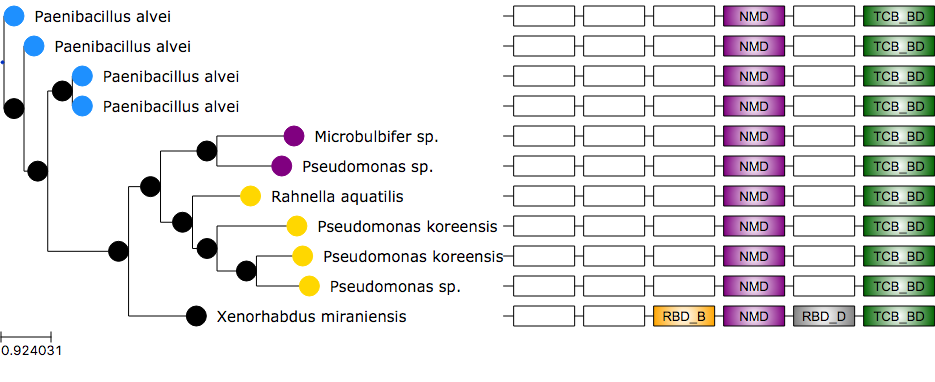

defaultdict(<class 'list'>, {'RBD_B': ['NZ_NITZ01000138.1_info_Xenorhabdus_miraniensis_TcdA1_expanded_position_4356427_4363996_backward']})
For domain RBD_B we have to add 1 sequence

Sequences where we found domains are - Xenorhabdus miraniensis

Searching for domains 

Setup the domain directories 

Searching the sequences with the profiles

Profile name is leidreiter_profiles_output_1
Profile dir is /Users/gabefoley/Dropbox/PhD/Projects/Phylo_Island/2020/20200309_RBD/20200331_RBD_Notebook/profiles/leidreiter_profiles_output_1
This is the current tree 



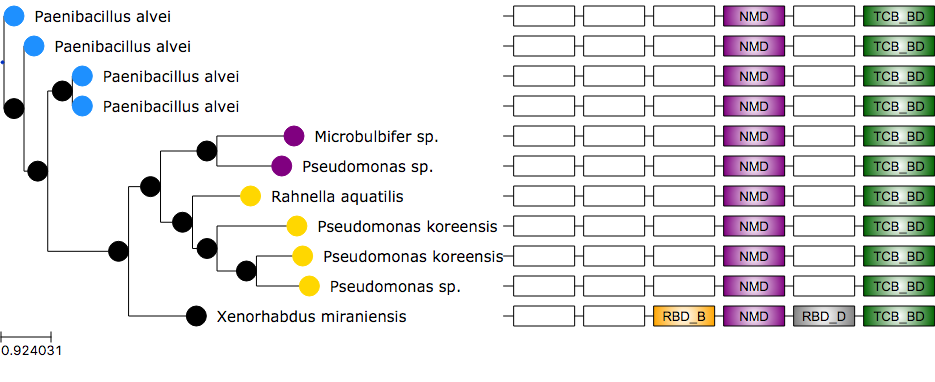

No new domains discovered


In [46]:
import sequence
import os
import shutil
import subprocess
import shutil
import glob
import pickle
from collections import defaultdict
from Bio import SearchIO
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node, SeqMotifFace, NodeStyle, faces, ImgFace, CircleFace, AttrFace
from src.attributes import attribute_dict

# Create and setup the working directory
file_dir = setup_working_dir(base_dir, filename)

# Move into the working directory
os.chdir(file_dir)

# Load the sequences
regions = sequence.readFastaFile(f'{filename}.fasta')

# If we haven't already, make an alignment a tree and place the outgroup correctly
make_alignment(filename)
make_tree(filename)
place_outgroup(filename, outgroup)

# # Load the tree
# tree = Tree(f'{filename}.nwk', format=1)

# Search for domains in the sequences
output_tree = search_domains(base_dir, filename, file_dir, profile_name)
# print (output_tree)
# Output the coloured tips image to the notebook
# output_tree[0].render("%%inline", dpi=300, tree_style=output_tree[1])